<a href="https://colab.research.google.com/github/anushreechaudhuri/HOT-dataset-analysis/blob/master/proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Isolating factors for each microbial population**

First I want to look at which factors have the greatest weights/correlations to heterotroph populations, dinoflagellates, plankton, and cyanobacteria. The potential factors include seawater pH, pCO₂, temperature, redox chemistry, irradiance, primary production rates, pigmentation and chlorophyll counts, and nutrient availability, as well as the other microbial community populations (excluding the one being isolated). This can be done statistically through correlative analysis or clustering or by feeding all this in to an algorithm which learns relative weights that signify the relevance of each factor.

# **2. Using isolated factors to predict from time-series inputs**

Given these chosen "most-relevant" factors, I want to use a similar encoding recurrent prediction thing as Michael's work to be able to feed in the factors and numerically predict the microbial populations over time. Ideally the model should be able to learn from and then account for seasonal variability as well as interannual trends. End goal: feed in data that models the projected future climate (temperatures and pH as projected in the next few decade) or some perturbation of a factor (sudden extreme pH, huge HAB, lots of degrading biomass) and be able to predict, numerically and over time, the effects on the target microbial population.

We are (right now) using the HOT time-series dataset from ALOHA in Hawaii, which has been going for more than 28 years. In order to get data for these factors, I have to look at the following files and links:

* Primary production rates: .pp ftp://ftp.soest.hawaii.edu/hot/primary_production

* Incident Irradiance: .lic ftp://ftp.soest.hawaii.edu/hot/light/licor/

* Nutrients, temp, salinity, pH, most stuff: .sea ftp://ftp.soest.hawaii.edu/hot/water

* CTD (also temp, salinity, O2, etc): .ctd ftp://ftp.soest.hawaii.edu/hot/ctd

* Bacteria: .pp, .sea ftp://ftp.soest.hawaii.edu/hot/water

* Zooplankton: .net ftp://ftp.soest.hawaii.edu/hot/zooplankton




Ok, so I have all of these files. How can I use them?

First, I need to correlate every cruise to its specified date range (approx month). Then, based on the cruise number in the file name for every file type, I need to write the data columns for that file type and cruise number to one very very large csv with all the dates and cruise numbers, and get rid of columns that are irrelevant or too specific. I will have to account for time periods that are missing certain types of data from a cruise or times that had a different type of data collection method for a factor (new instrumentation, etc). With this large csv, it should be easier to analye stuff bc it'll have only what I need in a very consistent format and sorted by time.

In [0]:
'''
Make and download the csv with all the cruise nums and time stamps that I want to read from. Only need to run one time once working.
'''

In [0]:
'''
Here, I need to read from a csv that has all of the cruise numbers and corresponding dates (in time stamp preferably) into a MAIN dataframe. 
This dataframe will get everything else from the files ADDED as new columns to it by date/cruise.
Once everything has been added, I want to download this dataframe again as a csv. 

IDEALLY, I only will need to run this code ONE TIME to get the full csv file, which I can then open as a dataframe 
already perfectly formatted and make tensors with it, etc. 
'''

In [0]:
import pandas as pd
import subprocess

# Download a list of all the files in the column data dataset
!curl ftp://ftp.soest.hawaii.edu/hot/water/ -l | tail -n +3 >> col.csv

#Find the cruise number from the file name string
def cruiseNum(file_name):
  return int(''.join(filter(str.isdigit, file_name)))

# TEST: print('the cruise number for this thing is: ', cruiseNum('hot112.sea'))
# Load the list of files
with open('col.csv', 'r') as file:
    col_files = file.read().split()
    print(col_files)    
    
    # SORTING THE FILES BY CRUISE NUM/ALPHA
    sorted_files = sorted(col_files, key=cruiseNum)
full_data = None

for col_file in sorted_files:
  if(not col_file.endswith('.sea')):
    continue
    
  # download each file
  print(col_file)
  process = subprocess.Popen(['wget', 'ftp://ftp.soest.hawaii.edu/hot/water/' + col_file, '-O', col_file], stdout=subprocess.PIPE)
  output, error = process.communicate()
  
  print(error)
  print(output)
  # First remove the column information which is stored between the ****'s
  lines = open(col_file).readlines()
  with open(col_file, 'w') as f:
      f.writelines(lines[5:])
      
  
  # Then load the txt file into pandas
  data = pd.read_csv(col_file, delim_whitespace=True, header=None)
  data.columns = lines[1].split()
  
  if(full_data is None):
    full_data = data
  else:
    full_data = pd.concat([full_data,data], axis=1)
    
  break

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6980    0  6980    0     0   3952      0 --:--:--  0:00:01 --:--:--  3952
['ac1.sea', 'ac2.sea', 'ha1.sea', 'ha2.sea', 'ha3.sea', 'ha4.sea', 'ha5.sea', 'hot1.gof', 'hot1.sea', 'hot10.gof', 'hot10.sea', 'hot100.gof', 'hot100.sea', 'hot101.gof', 'hot101.sea', 'hot102.gof', 'hot102.sea', 'hot103.gof', 'hot103.sea', 'hot104.gof', 'hot104.sea', 'hot105.gof', 'hot105.sea', 'hot106.gof', 'hot106.sea', 'hot107.gof', 'hot107.sea', 'hot108.gof', 'hot108.sea', 'hot109.gof', 'hot109.sea', 'hot11.gof', 'hot11.sea', 'hot110.gof', 'hot110.sea', 'hot111.gof', 'hot111.sea', 'hot112.gof', 'hot112.sea', 'hot113.gof', 'hot113.sea', 'hot114.gof', 'hot114.sea', 'hot115.gof', 'hot115.sea', 'hot116.gof', 'hot116.sea', 'hot117.gof', 'hot117.sea', 'hot118.gof', 'hot118.sea', 'hot119.gof', 'hot119.sea', 'hot12.gof', 'hot12.sea', 'hot120.gof', 'hot120.s

In [0]:
print(full_data.head(100))

import numpy as np

salinity = full_data['SALNTY'].values
temp = full_data['CTDTMP'].values


    STNNBR  CASTNO  SAMPNO  BTLNBR  ...  PHSPHT  REVPRS  REVTMP    QUALT1
0        1       1      24      31  ...   -9.00    -9.0    -9.0  22225555
1        1       1      23      30  ...    0.06    -9.0    -9.0  22222222
2        1       1      22      22  ...    0.06    -9.0    -9.0  22222222
3        1       1      21      21  ...    0.06    -9.0    -9.0  22222222
4        1       1      20      20  ...    0.06    -9.0    -9.0  22222222
5        1       1      19      19  ...    0.05    -9.0    -9.0  22222222
6        1       1      18      18  ...    0.06    -9.0    -9.0  22222222
7        1       1      17      17  ...    0.04    -9.0    -9.0  22222222
8        1       1      16      16  ...    0.03    -9.0    -9.0  22222222
9        1       1      15      15  ...    0.03    -9.0    -9.0  22222222
10       1       1      14      14  ...    0.05    -9.0    -9.0  22222222
11       1       1      13      13  ...    0.09    -9.0    -9.0  22222222
12       1       1      12      12  ..

In [0]:
import torch

# salinity = torch.from_numpy(salinity)

(301,)
(301,)


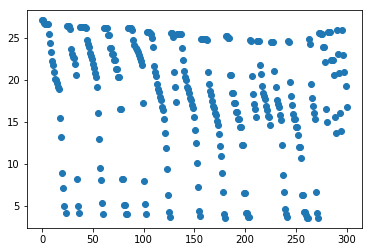

In [0]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
print(salinity.shape)
print(temp.shape)
t = np.arange(0, 301)
plt.scatter(t, temp)

# (input[channel] - mean[channel]) / std[channel]
# salinity = (salinity - salinity.mean()) / salinity.std()
# print(salinity[0:5])

In [0]:
import torch.nn as nn

torch.set_default_tensor_type('torch.DoubleTensor')


net = nn.Linear(301, 10)
print(net(salinity.double()))

tensor([-0.3546,  0.0108, -0.8264,  1.5989,  0.2340, -0.2469, -0.0292,  0.7096,
        -0.0446, -0.3908], grad_fn=<AddBackward0>)


In [0]:
# Hyperparameters for our network
input_size = 301
hidden_sizes = [200, 50]
output_size = 1

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
# images, labels = next(iter(trainloader))
# images.resize_(images.shape[0], 1, 784)
ps = model.forward(salinity)
# helper.view_classify(images[0].view(1, 28, 28), ps)

Sequential(
  (0): Linear(in_features=301, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
  (5): Softmax()
)


IndexError: ignored